# Imports

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import importlib, functions
importlib.reload(functions)
from functions import polynomial_features, Ridge_parameters
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import (
    PolynomialFeatures,
)  # use the fit_transform method of the created object!
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

# Bias-Variance trade-off

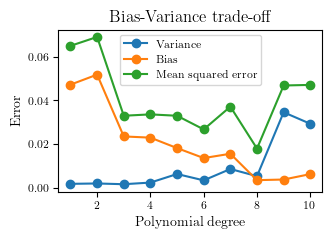

In [23]:
n = 100
bootstraps = 1000

# Define the function without the noise
def f(x):
    return np.exp(-(x**2)) + 1.5 * np.exp(-((x - 2) ** 2))

x = np.linspace(-3, 3, n)
y = f(x) + np.random.normal(0, 0.1, size=n)

biases = []
variances = []
mses = []

x = x.reshape(-1, 1)
deg_min = 1
deg_max = 10

# Fixed train/test-split used on all degrees for comparable results
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=123)
n_test_points = len(y_test)
n_train_points = len(y_train)

# noiseless target on the fixed test inputs (for bias only)
f_test = f(x_test.ravel())

for p in range(deg_min, deg_max + 1):
    # Make polynomial features
    poly_features = PolynomialFeatures(degree=p)

    # Built design matrix (fixed train/test-split)
    X_train = poly_features.fit_transform(x_train)
    X_test  = poly_features.transform(x_test)

    # Make array for predictions
    predictions = np.zeros((bootstraps, n_test_points))
    # Define targets (noisy) for MSE
    target = y_test

    for b in range(bootstraps):
        # Make bootstrap sample
        X_train_re, y_train_re = resample(
            X_train, y_train, n_samples=n_train_points, random_state=b
        )
        # Fit model on the sample data:
        poly_model = LinearRegression(fit_intercept=False).fit(X_train_re, y_train_re)
        # Make predictions on test data:
        poly_predict = poly_model.predict(X_test)
        # Add predictions to array
        predictions[b, :] = poly_predict

    # Calculate bias against the noiseless function on the fixed test inputs
    pred_mean = np.mean(predictions, axis=0)
    biases.append(np.mean((pred_mean - f_test)**2))

    # Calculate variance (per test point over bootstraps, then average)
    var_per_point = np.mean((predictions - pred_mean)**2, axis=0)
    variances.append(np.mean(var_per_point))

    # Calculate MSE against the noisy targets
    mses.append(np.mean((predictions - target)**2))

# Plotting results

# ---- Sett LaTeX-font og størrelser til å matche revtex4 (10 pt) ----
plt.rcParams.update({
    "text.usetex": True,       # bruk LaTeX for tekst
    "font.family": "serif",    # Computer Modern Serif
    "font.size": 10,           # revtex4 default 10 pt
    "axes.labelsize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

# ---- Konverter kolonnebredde fra pt til inches for matplotlib ----
pt_per_inch = 72.27
columnwidth_pt = 246.0  # fra LaTeX \columnwidth
fig_width_in = columnwidth_pt / pt_per_inch

# Valgfri høyde: bruk gyllen ratio eller annen
golden_ratio = 1.618
fig_height_in = fig_width_in / golden_ratio

# ---- Lag figur med riktig bredde ----
fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in))

degrees = np.arange(deg_min, deg_max + 1)
plt.plot(degrees, variances, marker="o", label="Variance")
plt.plot(degrees, biases, marker="o", label="Bias")
plt.plot(degrees, mses, marker="o", label="Mean squared error")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.title("Bias-Variance trade-off")
plt.legend()
plt.show()

fig.tight_layout()
fig.savefig("bias_variance.pdf", bbox_inches='tight')

# Heat map

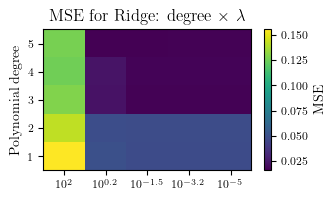

In [24]:
n = 100
x = np.linspace(-3, 3, n)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2) + np.random.normal(0, 0.1)



# ----- LaTeX-match: font og figurstørrelse (revtex4, 10 pt) -----
plt.rcParams.update({
    "text.usetex": True,     # bruk LaTeX-rendering
    "font.family": "serif",  # Computer Modern
    "font.size": 10,         # revtex4 default 10 pt
    "axes.labelsize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

# Velg bredde: én kolonne (246 pt) eller full bredde (510 pt)
COLUMNWIDTH_PT = 246.0
TEXTWIDTH_PT   = 510.0
USE_FULL_WIDTH = False  # sett True hvis du vil ha figur i full bredde (to kolonner)

PT_PER_INCH = 72.27
fig_width_in = (TEXTWIDTH_PT if USE_FULL_WIDTH else COLUMNWIDTH_PT) / PT_PER_INCH
golden = 1.618
fig_height_in = fig_width_in / golden

# ----- Grid for grader og lambda -----
degrees = np.arange(1, 6)              # 1,2,3,4,5
lambdas = np.logspace(2, -5, num=5)    # 1e2 ... 1e-5
MSE = np.zeros((len(degrees), len(lambdas)))

# ----- Train/test-splitt -----
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# ----- Beregn MSE over hele gridet -----
for i, deg in enumerate(degrees):
    # Feature-matriser
    X_train = polynomial_features(x_train, deg)
    X_test  = polynomial_features(x_test, deg)

    # Skaler X
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # Merk: Følger mønsteret ditt med y-offset (hvis modellen ikke håndterer intercept)
    y_offset = float(np.mean(y_train))

    for j, lam in enumerate(lambdas):
        # Estimer parametre
        beta = Ridge_parameters(X_train_s, y_train, lam)

        # Prediksjon på test
        y_test_pred = X_test_s @ beta + y_offset

        # MSE
        MSE[i, j] = mean_squared_error(y_test, y_test_pred)

# ----- Plot: Heatmap -----
fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in))

im = ax.imshow(
    MSE,
    origin="lower",           # grad=1 nederst
    aspect="auto",
    interpolation="nearest"
)

# Akser og ticks
ax.set_title(r"MSE for Ridge: degree $\times$ $\lambda$")
ax.set_ylabel("Polynomial degree")
ax.set_yticks(np.arange(len(degrees)))
ax.set_yticklabels([str(d) for d in degrees])

# Pen log10-tekst for lambda-aksen
exps = np.log10(lambdas)
xticklabels = [
    fr"$10^{{{int(round(e))}}}$" if np.isclose(e, round(e)) else fr"$10^{{{e:.1f}}}$"
    for e in exps
]
ax.set_xticks(np.arange(len(lambdas)))
ax.set_xticklabels(xticklabels)

# Fargeskala
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("MSE")

fig.tight_layout()
fig.savefig("ridge_heatmap.pdf", bbox_inches="tight")  # vektor-PDF for LaTeX
# plt.show()  # valgfritt ved interaktiv kjøring